Spline Approximation
========

# Theory

**Spline approximation** uses piecewise polynomial functions to approximate data while maintaining smoothness. Unlike interpolating splines (which pass through all data points), **smoothing splines** balance data fidelity against smoothness.

## Interpolating vs. Smoothing Splines

**Interpolating splines** pass exactly through all data points but can be sensitive to noise.

**Smoothing splines** trade off fitting the data exactly for a smoother curve, making them more robust to noise.

## Cubic Smoothing Spline

Given $n$ data points $(x_i, y_i)$, a cubic smoothing spline minimizes:
$$
\sum_{i=1}^n (y_i - g(x_i))^2 + \lambda \int_a^b (g''(x))^2 dx
$$

where:
- The first term measures **data fidelity** (how well the spline fits the data)
- The second term measures **roughness** (penalizes curvature)
- $\lambda \geq 0$ is the **smoothing parameter** controlling the trade-off

### Smoothing Parameter $\lambda$

- $\lambda = 0$: Interpolating cubic spline (passes through all points)
- $\lambda \to \infty$: Least squares linear regression (straight line)
- Intermediate $\lambda$: Balanced smoothing

## Natural Cubic Spline Properties

A natural cubic spline $S(x)$ on $[x_1, x_n]$ satisfies:
1. $S(x)$ is a cubic polynomial on each interval $[x_i, x_{i+1}]$
2. $S(x)$, $S'(x)$, and $S''(x)$ are continuous on $[x_1, x_n]$
3. $S''(x_1) = S''(x_n) = 0$ (natural boundary conditions)

## Algorithm for Natural Cubic Spline

For each interval $[x_i, x_{i+1}]$, the cubic spline is:
$$
S_i(x) = a_i + b_i(x - x_i) + c_i(x - x_i)^2 + d_i(x - x_i)^3
$$

The coefficients are found by solving a tridiagonal system ensuring continuity conditions.

# Implementation

## Imports

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

## Parameters

In [35]:
# Data generation parameters
N = 20                    # number of data points
a, b = 0, 2*np.pi         # interval
noise_std = 0.3           # noise level

# True underlying function
f_true = lambda x: np.sin(x)

## Algorithm

```mermaid
    flowchart LR
        data(Input data points) --> solve(Solve tridiagonal system)
        solve --> coeffs(Compute spline coefficients)
        coeffs --> eval(Evaluate spline)
```

In [36]:
def solve_tridiagonal(lower: np.ndarray, diag: np.ndarray, 
                      upper: np.ndarray, rhs: np.ndarray) -> np.ndarray:
    '''
    Solve tridiagonal system using Thomas algorithm.
    
    Args:
        lower: Sub-diagonal elements
        diag: Diagonal elements  
        upper: Super-diagonal elements
        rhs: Right-hand side vector
    
    Returns:
        Solution vector
    '''
    n = len(rhs)
    c_prime = np.zeros(n - 1)
    d_prime = np.zeros(n)
    
    # Forward sweep
    c_prime[0] = upper[0] / diag[0]
    d_prime[0] = rhs[0] / diag[0]
    
    for i in range(1, n - 1):
        denom = diag[i] - lower[i] * c_prime[i-1]
        c_prime[i] = upper[i] / denom
        d_prime[i] = (rhs[i] - lower[i] * d_prime[i-1]) / denom
    
    d_prime[n-1] = (rhs[n-1] - lower[n-1] * d_prime[n-2]) / (diag[n-1] - lower[n-1] * c_prime[n-2])
    
    # Back substitution
    x = np.zeros(n)
    x[n-1] = d_prime[n-1]
    for i in range(n - 2, -1, -1):
        x[i] = d_prime[i] - c_prime[i] * x[i+1]
    
    return x

In [37]:
def natural_cubic_spline(x: np.ndarray, y: np.ndarray) -> tuple:
    '''
    Compute natural cubic spline coefficients.
    
    Args:
        x: Data point x-coordinates (sorted)
        y: Data point y-coordinates
    
    Returns:
        Tuple of coefficient arrays (a, b, c, d) for each interval
    '''
    n = len(x) - 1
    h = np.diff(x)  # interval widths
    
    # Build tridiagonal system for c coefficients
    # Ac = rhs where A is tridiagonal
    diag = np.zeros(n + 1)
    diag[0] = diag[n] = 1
    diag[1:n] = 2 * (h[:-1] + h[1:])
    
    # Off-diagonals need size n+1 to match diag (first/last elements unused)
    off_diag_lower = np.zeros(n + 1)
    off_diag_lower[1:n] = h[:-1]
    
    off_diag_upper = np.zeros(n + 1)
    off_diag_upper[1:n] = h[1:]
    
    rhs = np.zeros(n + 1)
    rhs[1:n] = 3 * (np.diff(y[1:]) / h[1:] - np.diff(y[:-1]) / h[:-1])
    
    # Solve tridiagonal system using Thomas algorithm
    c = solve_tridiagonal(off_diag_lower, diag, off_diag_upper, rhs)
    
    # Compute remaining coefficients
    a = y[:-1].copy()
    b = np.diff(y) / h - h * (2*c[:-1] + c[1:]) / 3
    d = np.diff(c) / (3 * h)
    
    return a, b, c[:-1], d

In [38]:
def evaluate_spline(x_eval: np.ndarray, x_data: np.ndarray, 
                    a: np.ndarray, b: np.ndarray, 
                    c: np.ndarray, d: np.ndarray) -> np.ndarray:
    '''
    Evaluate cubic spline at given points.
    
    Args:
        x_eval: Points at which to evaluate
        x_data: Original data x-coordinates
        a, b, c, d: Spline coefficients
    
    Returns:
        Spline values at x_eval points
    '''
    y_eval = np.zeros_like(x_eval)
    
    for i, x in enumerate(x_eval):
        # Find interval
        idx = np.searchsorted(x_data, x) - 1
        idx = np.clip(idx, 0, len(a) - 1)
        
        # Evaluate polynomial
        dx = x - x_data[idx]
        y_eval[i] = a[idx] + b[idx]*dx + c[idx]*dx**2 + d[idx]*dx**3
    
    return y_eval

## Results Visualization

We compare our natural cubic spline with scipy's smoothing spline at different smoothing levels.

In [39]:
# Generate noisy data
np.random.seed(42)
x_data = np.linspace(a, b, N)
y_true = f_true(x_data)
y_data = y_true + noise_std * np.random.randn(N)

# Compute natural cubic spline (interpolating)
a_coef, b_coef, c_coef, d_coef = natural_cubic_spline(x_data, y_data)

# Fine grid for evaluation
x_fine = np.linspace(a, b, 200)
y_spline = evaluate_spline(x_fine, x_data, a_coef, b_coef, c_coef, d_coef)

# Scipy smoothing splines with different smoothing factors
spline_s0 = interpolate.UnivariateSpline(x_data, y_data, s=0)  # interpolating
spline_s1 = interpolate.UnivariateSpline(x_data, y_data, s=1)  # light smoothing
spline_s5 = interpolate.UnivariateSpline(x_data, y_data, s=5)  # heavy smoothing

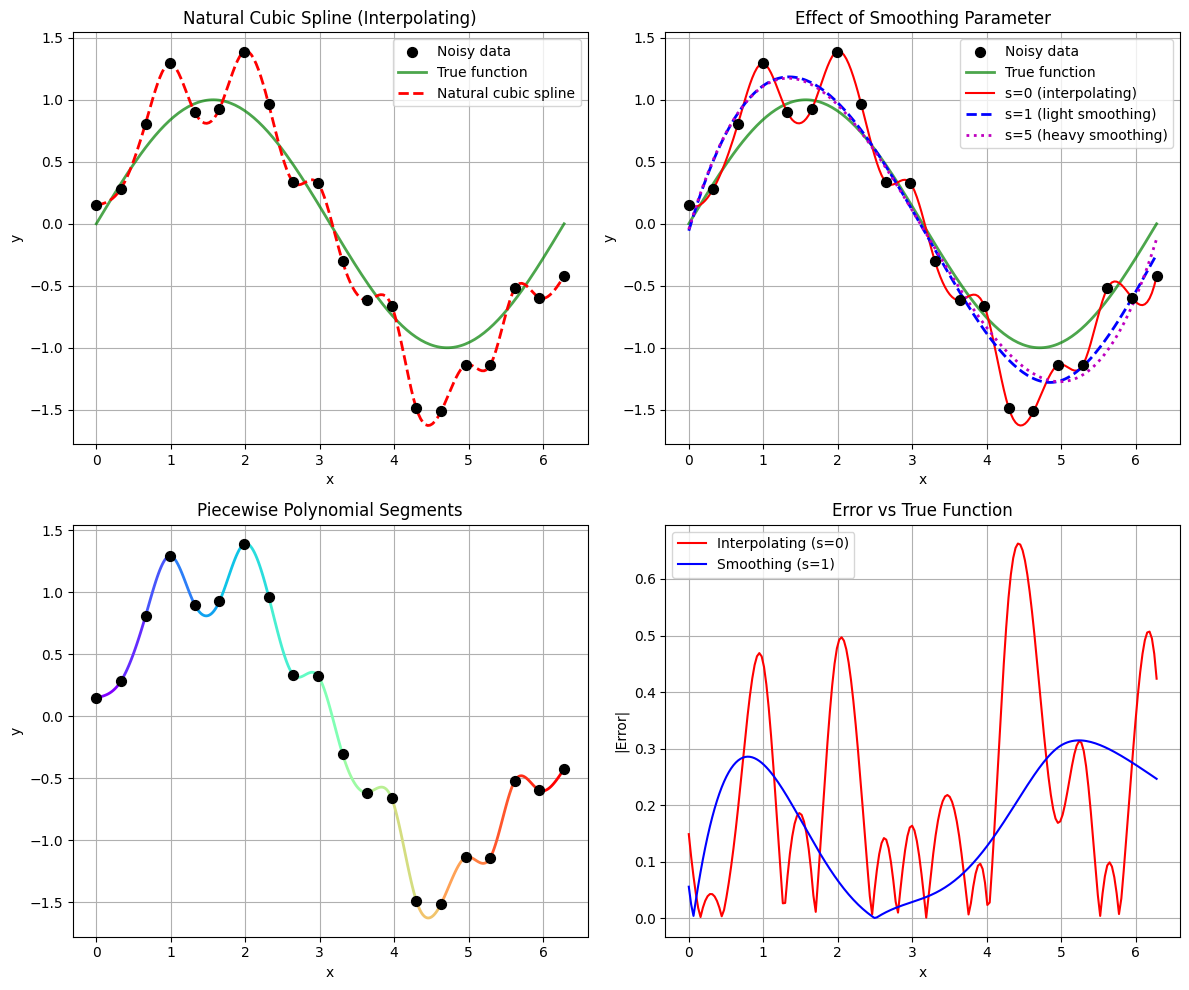

Mean absolute error (interpolating s=0): 0.2194
Mean absolute error (smoothing s=1):     0.1696


In [40]:
%matplotlib inline
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plot 1: Our natural cubic spline
axes[0, 0].scatter(x_data, y_data, c='black', s=50, label='Noisy data', zorder=5)
axes[0, 0].plot(x_fine, f_true(x_fine), 'g-', label='True function', linewidth=2, alpha=0.7)
axes[0, 0].plot(x_fine, y_spline, 'r--', label='Natural cubic spline', linewidth=2)
axes[0, 0].set(xlabel='x', ylabel='y', title='Natural Cubic Spline (Interpolating)')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Plot 2: Effect of smoothing parameter
axes[0, 1].scatter(x_data, y_data, c='black', s=50, label='Noisy data', zorder=5)
axes[0, 1].plot(x_fine, f_true(x_fine), 'g-', label='True function', linewidth=2, alpha=0.7)
axes[0, 1].plot(x_fine, spline_s0(x_fine), 'r-', label='s=0 (interpolating)', linewidth=1.5)
axes[0, 1].plot(x_fine, spline_s1(x_fine), 'b--', label='s=1 (light smoothing)', linewidth=2)
axes[0, 1].plot(x_fine, spline_s5(x_fine), 'm:', label='s=5 (heavy smoothing)', linewidth=2)
axes[0, 1].set(xlabel='x', ylabel='y', title='Effect of Smoothing Parameter')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Plot 3: Spline pieces visualization
colors = plt.cm.rainbow(np.linspace(0, 1, len(a_coef)))
for i in range(len(a_coef)):
    x_interval = np.linspace(x_data[i], x_data[i+1], 20)
    y_interval = evaluate_spline(x_interval, x_data, a_coef, b_coef, c_coef, d_coef)
    axes[1, 0].plot(x_interval, y_interval, color=colors[i], linewidth=2)
axes[1, 0].scatter(x_data, y_data, c='black', s=50, zorder=5)
axes[1, 0].set(xlabel='x', ylabel='y', title='Piecewise Polynomial Segments')
axes[1, 0].grid(True)

# Plot 4: Error comparison
error_interp = np.abs(spline_s0(x_fine) - f_true(x_fine))
error_smooth = np.abs(spline_s1(x_fine) - f_true(x_fine))
axes[1, 1].plot(x_fine, error_interp, 'r-', label='Interpolating (s=0)')
axes[1, 1].plot(x_fine, error_smooth, 'b-', label='Smoothing (s=1)')
axes[1, 1].set(xlabel='x', ylabel='|Error|', title='Error vs True Function')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Summary
print(f"Mean absolute error (interpolating s=0): {np.mean(error_interp):.4f}")
print(f"Mean absolute error (smoothing s=1):     {np.mean(error_smooth):.4f}")